In [1]:
import random
random.seed(7)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from keras.layers import Dense, Flatten, Embedding, Input, concatenate, Lambda, Dropout, multiply
from keras.regularizers import l2
from keras.models import Model, load_model, model_from_json
from keras.optimizers import Adam
import keras.backend as K
import tensorflow as tf

C:\Anaconda3\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [65]:
def evaluate_model(model, test, topK=10): #try using multiprocessing (in case this method is too slow)
    _hits = []
    print(' testing...')
    test['prediction'] = model.predict([test['user_id'], test['item_id']])
    users = test['user_id'].unique()
    for user in tqdm(users):
        user_topk = test[test['user_id']==user].nlargest(topK,'prediction')
        _hr = getHitRatio(user_topk)
        _hits.append(_hr)  
    return _hits

def getHitRatio(ranklist):
    for label in ranklist['labels']:
        if label == 1:
            return 1
    return 0

def save_model_json_GMF(model):
    model.save_weights('models/GMF_weights')
    model_json = model.to_json()
    with open("models/GMF_model.json", "w") as json_file:
        json_file.write(model_json)
    return None

def save_model_json_MLP(model):
    model.save_weights('models/MLP_weights')
    model_json = model.to_json()
    with open("models/MLP_model.json", "w") as json_file:
        json_file.write(model_json)
    return None

def save_model_json_NeuMF(model):
    model.save_weights('models/NeuMF_weights')
    model_json = model.to_json()
    with open("models/NeuMF_model.json", "w") as json_file:
        json_file.write(model_json)
    return None

def save_model_json_NeuMF_noTF(model):
    model.save_weights('models/NeuMF_noTF_weights')
    model_json = model.to_json()
    with open("models/NeuMF_noTF_model.json", "w") as json_file:
        json_file.write(model_json)
    return None

In [66]:
def calculate_neg_item_dict_by_user(data_ratings_all):
    dict_ = {}
    all_items_ = list(data_ratings_all['item_id'].unique())
    for user in tqdm(data_ratings_all['user_id'].unique()):
        pos_vector = list(data_ratings_all[data_ratings_all['user_id']==user].loc[:,'item_id'])
        neg_vector = list(set(all_items_)-set(pos_vector))
        dict_[user]=neg_vector
    return dict_

In [67]:
def add_neg_data(neg_dict, df_ratings, neg_num=1):
    user_vector=[]
    itemneg_vector=[]
    neglabels=[]
    for user in tqdm(df_ratings['user_id'].unique()):
        #take sample of negatives ( neg_num times df positives )
        df_pos_vector = list(df_ratings[df_ratings['user_id']==user].loc[:,'item_id'])
        neg_vector = list(random.sample(neg_dict[user], len(df_pos_vector)*neg_num))
        #createdata
        user_vector.extend([user]*(len(neg_vector)))
        itemneg_vector.extend(neg_vector)
        neglabels.extend([0]*len(neg_vector))
    dfdict_ = {'user_id':user_vector,'item_id':itemneg_vector,'labels':neglabels}
    df_negdata = pd.DataFrame(dfdict_)
    
    df = pd.concat([df_ratings, df_negdata],axis=0,ignore_index=True)
    df = df.sample(frac=1).reset_index(drop=True) #shuffle and reset index (drop old index)
    df = df.astype({"user_id": int, "item_id": int, "labels":int}) #convert to int
    
    return df

In [68]:
def GMF_paper(num_users, num_items,latent_dim=3,reg_layers=[0,0]):
    
    # Input variables
    user_input = Input(shape=(None,), name = 'user_input')
    item_input = Input(shape=(None,), name = 'item_input')
    
    MLP_Embedding_User = Embedding(input_dim = num_users,
                                   output_dim = latent_dim,
                                   name = 'user_embedding',
                                   embeddings_regularizer = l2(reg_layers[0]),
                                   input_length=1)
    MLP_Embedding_Item = Embedding(input_dim = num_items,
                                   output_dim = latent_dim,
                                   name = 'item_embedding',
                                   embeddings_regularizer = l2(reg_layers[0]),
                                   input_length=1)
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MLP_Embedding_User(user_input))
    item_latent = Flatten()(MLP_Embedding_Item(item_input))
    
    # Element-wise product of user and item embeddings 
    predict_vector = multiply([user_latent, item_latent])
    
    # Final prediction layer
    prediction = Dense(1, activation='sigmoid',
                       kernel_initializer='lecun_uniform',
                       name = 'prediction')(predict_vector)
    
    model = Model(input=[user_input, item_input], output=prediction)
    
    return model

In [69]:
def MLP_paper(num_users, num_items,layers = [64,32,16,8], reg_layers=[0,0,0,0]):
    num_layer = len(layers)
    user_lat_dim = 8 
    item_lat_dim = 10 
    
    # Input variables
    user_input = Input(shape=(None,), name = 'user_input')
    item_input = Input(shape=(None,), name = 'item_input')
    
    MLP_Embedding_User = Embedding(input_dim = num_users,
                                   output_dim = user_lat_dim,
                                   name = 'user_embedding',
                                   embeddings_regularizer = l2(reg_layers[0]),
                                   input_length=1)
    MLP_Embedding_Item = Embedding(input_dim = num_items,
                                   output_dim = item_lat_dim,
                                   name = 'item_embedding',
                                  embeddings_regularizer = l2(reg_layers[0]),
                                   input_length=1)
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MLP_Embedding_User(user_input))
    item_latent = Flatten()(MLP_Embedding_Item(item_input))
    
    user_latent_d = Dropout(0.1)(user_latent)
    item_latent_d = Dropout(0.1)(item_latent)
    
    # The 0-th layer is the concatenation of embedding layers
    vector = concatenate([user_latent_d, item_latent_d], axis=-1, name = 'concatenate_0')
    
    # MLP layers
    for idx in range(1, num_layer):
        layer = Dense(layers[idx], kernel_regularizer= l2(reg_layers[idx]),
                      activation='relu', name = 'layer%d' %idx)
        vector = layer(vector)
        
    # Final prediction layer
    prediction = Dense(1, activation='sigmoid',
                       kernel_initializer='lecun_uniform',
                       name = 'prediction')(vector)
    
    model = Model(input=[user_input, item_input], output=prediction)
    
    return model

In [70]:
def NeuMF_paper(num_users, num_items, gmf_dim=8, layers = [64,32,16,8], reg_layers=[0,0,0,0]):
    num_layer = len(layers) 
    user_lat_dim = 8 
    item_lat_dim = 10
    
    # Input variables
    user_input = Input(shape=(None,), name = 'user_input')
    item_input = Input(shape=(None,), name = 'item_input')
    
    # Embedding layer
    GMF_Embedding_User = Embedding(input_dim = num_users,output_dim = gmf_dim,
                                   name = 'gmf_embedding_user',
                                   embeddings_regularizer = l2(reg_layers[0]),
                                   input_length=1)
    GMF_Embedding_Item = Embedding(input_dim = num_items,output_dim = gmf_dim,
                                   name = 'gmf_embedding_item',
                                   embeddings_regularizer = l2(reg_layers[0]),
                                   input_length=1)  

    MLP_Embedding_User = Embedding(input_dim = num_users,output_dim = user_lat_dim,
                                   name = "mlp_embedding_user",
                                   embeddings_regularizer = l2(reg_layers[0]),
                                   input_length=1)
    MLP_Embedding_Item = Embedding(input_dim = num_items,output_dim = item_lat_dim,
                                   name = 'mlp_embedding_item',
                                   embeddings_regularizer = l2(reg_layers[0]),
                                   input_length=1)   
    
    # MF part
    gmf_user_latent = Flatten()(GMF_Embedding_User(user_input))
    gmf_item_latent = Flatten()(GMF_Embedding_Item(item_input))
    gmf_vector = multiply([gmf_user_latent, gmf_item_latent]) # element-wise multiply

    # MLP part 
    mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
    mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
    mlp_user_latent_d = Dropout(0.5)(mlp_user_latent)
    mlp_item_latent_d = Dropout(0.5)(mlp_item_latent)
    mlp_vector = concatenate([mlp_user_latent_d, mlp_item_latent_d],axis=-1, name = 'concatenate_0')
    for idx in range(1, num_layer):
        layer = Dense(layers[idx], kernel_regularizer= l2(reg_layers[idx]),
                      activation='relu', name="layer%d" %idx)
        mlp_vector = layer(mlp_vector)

    # Concatenate MF and MLP parts
    predict_vector = concatenate([gmf_vector, mlp_vector], axis=-1, name = 'concatenate_1')
    
    # Final prediction layer
    prediction = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform',
                       name = "prediction")(predict_vector)
    
    model = Model(input=[user_input, item_input], output=prediction)
    
    return model

In [71]:
def getdata(data_path):
    print('Reading data ... ')
    all_ratings = pd.read_csv(data_path, sep='\t',header=None)
    all_ratings = all_ratings.drop(columns=[1])
    all_ratings = all_ratings.dropna() 
    all_ratings.columns=['user','item','plays']
    all_ratings = all_ratings[all_ratings.plays!=0] # drop rows with plays number iqual to 0
    
    print('Droping items with less than 10 times beeing used ... ')
    all_ratings = all_ratings[all_ratings.groupby('item')['item'].transform('count').ge(10)]
    print('Droping users with lens than 75 items ... ')
    all_ratings = all_ratings[all_ratings.groupby('user')['user'].transform('count').ge(75)]
    print('All Items: ', len(all_ratings.item.unique()))
    print('All Users: ', len(all_ratings.user.unique()))
    print('All ratings: ', len(all_ratings))
    # Take only user that appears more than 10 times. This means that the users have 10 or more items

    # print(all_data[all_data.isnull().any(axis=1)]) #show nulls
    
    print('Creating categories and diccionary item_id to item ... ')
    all_ratings["user"] = all_ratings["user"].astype('category')
    all_ratings["item"] = all_ratings["item"].astype('category')

    all_ratings["user_id"] = all_ratings["user"].cat.codes
    all_ratings["item_id"] = all_ratings["item"].cat.codes
    all_ratings = all_ratings.drop(columns='user')
    all_ratings['labels']=1
    
    itemid2item = dict(set(list(zip(all_ratings.item_id, all_ratings.item))))
    
    print(all_ratings.head())
    
    return all_ratings, itemid2item

In [72]:
def split_train_test(all_ratings):
    print('Creating diccionary user to negative items ... ')
    user_2_neg_items_vect = calculate_neg_item_dict_by_user(all_ratings)
    
    print('Creating test data and training ratings ...')
    test_ratings = all_ratings.groupby('user_id', group_keys=False).apply(lambda df: df.sample(1,random_state=7))
    test_data = add_neg_data(user_2_neg_items_vect,test_ratings,neg_num=100)
    print('Test data: ',len(test_data))
    print('Test Items: ',len(test_data.item.unique()))
    print('Test Users: ',len(test_data.user_id.unique()))
    
    train_ratings = all_ratings.drop(list(test_ratings.index))
    print('Train ratings: ', len(train_ratings))
    
    return train_ratings, test_data, user_2_neg_items_vect

In [73]:
def train_GMF(data_ratings,train_ratings,test_data,user_2_neg_items_vect,num_epochs):
    n_users = data_ratings['user_id'].nunique()
    n_items = data_ratings['item_id'].nunique()
    
    GMF = GMF_paper(n_users, n_items, latent_dim=8)
    GMF.summary()
    
    GMF.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
    best_hr = -1
    hr_vect = []
    for i in range(num_epochs):
        epoch = i+1
        print('EPOCH:',epoch,'-'*80)
        print(' generating negatives...')
        train_data = add_neg_data(user_2_neg_items_vect,train_ratings)
        print(' training...')
        hist_ = GMF.fit(x=[train_data['user_id'], train_data['item_id']], y=train_data['labels'],
                epochs=1, batch_size=int(8192/2), shuffle=True, verbose=2)

        # Evaluation (IMPLEMENTAR LAS METRICAS SEGUN EL PAPER) (REVISAR CODIGO DEL PAPER EN GITHUB)
        hits = evaluate_model(GMF, test_data, topK=10)
        hr,loss,acc  = np.array(hits).mean(), hist_.history['loss'][0],hist_.history['acc'][0]
        hr_vect.append(hr)
        print(' epoch %d --> loss = %.4f, ACC = %.4f, HR = %.4f'
              % (epoch,loss,acc,hr))
        if hr > best_hr:
            print(' Best model found!')
            best_hr, best_epoch = hr, epoch
            save_model_json_GMF(GMF)

        np.save('metric/hr_vect_GMF',hr_vect)
    
    return None

In [101]:
def train_MLP(data_ratings,train_ratings,test_data,user_2_neg_items_vect,num_epochs):
    n_users = data_ratings['user_id'].nunique()
    n_items = data_ratings['item_id'].nunique()
    
    MLP = MLP_paper(n_users, n_items)
    MLP.summary()
    
    MLP.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy']) #0.005
    
    best_hr = -1
    hr_vect = []
    for i in range(num_epochs):
        epoch = i+1
        print('EPOCH:',epoch,'-'*80)
        print(' generating negatives...')
        train_data = add_neg_data(user_2_neg_items_vect,train_ratings)
        print(' training...')
        hist_ = MLP.fit(x=[train_data['user_id'], train_data['item_id']], y=train_data['labels'],
                epochs=1, batch_size=int(8192/2), shuffle=True, verbose=2)

        # Evaluation (IMPLEMENTAR LAS METRICAS SEGUN EL PAPER) (REVISAR CODIGO DEL PAPER EN GITHUB)
        hits = evaluate_model(MLP, test_data, topK=10)
        hr,loss,acc  = np.array(hits).mean(), hist_.history['loss'][0],hist_.history['acc'][0]
        hr_vect.append(hr)
        print(' epoch %d --> loss = %.4f, ACC = %.4f, HR = %.4f'
              % (epoch,loss,acc,hr))
        if hr > best_hr:
            print(' Best model found!')
            best_hr, best_epoch = hr, epoch
            save_model_json_MLP(MLP)

        np.save('metric/hr_vect_MLP',hr_vect)
    
    return None

In [116]:
def train_model_NeuMF(data_ratings, train_ratings, test_data,user_2_neg_items_vect ,num_epochs, pre_train=True):
    
    def load_pretrain_model(model, gmf_model, mlp_model, num_layers=len([64,32,16,8])):
        # MF embeddings
        gmf_user_embeddings = gmf_model.get_layer('user_embedding').get_weights()
        gmf_item_embeddings = gmf_model.get_layer('item_embedding').get_weights()
        model.get_layer('gmf_embedding_user').set_weights(gmf_user_embeddings)
        model.get_layer('gmf_embedding_item').set_weights(gmf_item_embeddings)

        # MLP embeddings
        mlp_user_embeddings = mlp_model.get_layer('user_embedding').get_weights()
        mlp_item_embeddings = mlp_model.get_layer('item_embedding').get_weights()
        model.get_layer('mlp_embedding_user').set_weights(mlp_user_embeddings)
        model.get_layer('mlp_embedding_item').set_weights(mlp_item_embeddings)

        # MLP layers
        for i in range(1, num_layers):
            mlp_layer_weights = mlp_model.get_layer('layer%d' %i).get_weights()
            model.get_layer('layer%d' %i).set_weights(mlp_layer_weights)

        # Prediction weights
        gmf_prediction = gmf_model.get_layer('prediction').get_weights()
        mlp_prediction = mlp_model.get_layer('prediction').get_weights()
        new_weights = np.concatenate((gmf_prediction[0], mlp_prediction[0]), axis=0)
        new_b = gmf_prediction[1] + mlp_prediction[1]
        model.get_layer('prediction').set_weights([0.5*new_weights, 0.5*new_b])    
        return model
    
    n_users = data_ratings['user_id'].nunique()
    n_items = data_ratings['item_id'].nunique()
    
    NeuMF = NeuMF_paper(n_users, n_items)
    print(NeuMF.summary())
    
    NeuMF.compile(optimizer=Adam(lr=0.005), loss='binary_crossentropy', metrics=['accuracy']) #0.0001
    
    # Load pretrain model
    if pre_train:
        print("Loading pre-train weights ... ")
        gmf_model = GMF_paper(n_users,n_items,latent_dim=8)
        gmf_model.load_weights('models/GMF_weights')
        mlp_model = MLP_paper(n_users,n_items)
        mlp_model.load_weights('models/MLP_weights')
        NeuMF = load_pretrain_model(NeuMF, gmf_model, mlp_model)
        print("Load pretrained GMF (%s) and MLP (%s) models done. ")
        
    # trainig loop
    best_hr = -1
    hr_vect = []
    loss_vect = []
    print('Trainig loop...')
    for i in range(num_epochs):
        epoch = i+1
        print('EPOCH:',epoch,'-'*80)
        print(' generating negatives...')
        train_data = add_neg_data(user_2_neg_items_vect,train_ratings)
        print(' training...')
        hist_ = NeuMF.fit(x=[train_data['user_id'], train_data['item_id']], y=train_data['labels'],
                epochs=1, batch_size=int(8192/2), shuffle=True, verbose=2)

        # Evaluation (IMPLEMENTAR LAS METRICAS SEGUN EL PAPER) (REVISAR CODIGO DEL PAPER EN GITHUB)
        hits = evaluate_model(NeuMF, test_data, topK=10)
        hr,loss,acc  = np.array(hits).mean(), hist_.history['loss'][0],hist_.history['acc'][0]
        hr_vect.append(hr)
        print(' epoch %d --> loss = %.4f, ACC = %.4f, HR = %.4f'
              % (epoch,loss,acc,hr))
        if hr > best_hr:
            print(' Best model found!')
            best_hr, best_epoch = hr, epoch
            if pre_train:
                save_model_json_NeuMF(NeuMF)
            else:
                save_model_json_NeuMF_noTF(NeuMF)
                                           
        if pre_train:
            np.save('metric/hr_vect_NeuMF',hr_vect)
        else:
            np.save('metric/hr_vect_NeuMF_noTF',hr_vect)
            
    return None

In [76]:
path = '../data/lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv'

In [77]:
all_ratings, itemid2item  = getdata(path)

Reading data ... 
Droping items with less than 10 times beeing used ... 
Droping users with lens than 75 items ... 
All Items:  32278
All Users:  2526
All ratings:  205629
Creating categories and diccionary item_id to item ... 
                        item  plays  user_id  item_id  labels
4235               pj harvey    394        0    22261       1
4236               radiohead    201        0    22928       1
4237                  zero 7    182        0    31845       1
4238  einstürzende neubauten    106        0     9129       1
4239             david bowie    104        0     7188       1


In [78]:
train_ratings, test_data, user_2_neg_items_vect = split_train_test(all_ratings)

Creating diccionary user to negative items ... 


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:12<00:00, 201.77it/s]


Creating test data and training ratings ...


100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1189.85it/s]
C:\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  app.launch_new_instance()


Test data:  255126
Test Items:  2023
Test Users:  2526
Train ratings:  203103


In [80]:
train_GMF(all_ratings,train_ratings,test_data,user_2_neg_items_vect,num_epochs=10)

C:\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, None)         0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         (None, None)         0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 8)         20208       user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 8)         258224      item_input[0][0]                 
__________________________________________________________________________________________________
flatten_9 

100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1127.68it/s]
C:\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  app.launch_new_instance()


 training...
Epoch 1/1
 - 1s - loss: 0.6931 - acc: 0.4990
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:05<00:00, 500.40it/s]


 epoch 1 --> loss = 0.6931, ACC = 0.4990, HR = 0.1120
 Best model found!
EPOCH: 2 --------------------------------------------------------------------------------
 generating negatives...


100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1191.52it/s]


 training...
Epoch 1/1
 - 0s - loss: 0.6931 - acc: 0.5081
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:04<00:00, 521.04it/s]


 epoch 2 --> loss = 0.6931, ACC = 0.5081, HR = 0.1374
 Best model found!
EPOCH: 3 --------------------------------------------------------------------------------
 generating negatives...


100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1163.54it/s]


 training...
Epoch 1/1
 - 0s - loss: 0.6927 - acc: 0.5896
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:04<00:00, 527.25it/s]


 epoch 3 --> loss = 0.6927, ACC = 0.5896, HR = 0.3828
 Best model found!
EPOCH: 4 --------------------------------------------------------------------------------
 generating negatives...


100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1197.72it/s]


 training...
Epoch 1/1
 - 0s - loss: 0.6865 - acc: 0.7246
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:04<00:00, 521.69it/s]


 epoch 4 --> loss = 0.6865, ACC = 0.7246, HR = 0.5871
 Best model found!
EPOCH: 5 --------------------------------------------------------------------------------
 generating negatives...


100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1156.07it/s]


 training...
Epoch 1/1
 - 0s - loss: 0.6518 - acc: 0.7654
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:04<00:00, 531.23it/s]


 epoch 5 --> loss = 0.6518, ACC = 0.7654, HR = 0.6085
 Best model found!
EPOCH: 6 --------------------------------------------------------------------------------
 generating negatives...


100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1161.36it/s]


 training...
Epoch 1/1
 - 0s - loss: 0.5855 - acc: 0.7652
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:04<00:00, 528.46it/s]


 epoch 6 --> loss = 0.5855, ACC = 0.7652, HR = 0.6132
 Best model found!
EPOCH: 7 --------------------------------------------------------------------------------
 generating negatives...


100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1161.37it/s]


 training...
Epoch 1/1
 - 0s - loss: 0.5263 - acc: 0.7700
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:04<00:00, 508.78it/s]


 epoch 7 --> loss = 0.5263, ACC = 0.7700, HR = 0.6144
 Best model found!
EPOCH: 8 --------------------------------------------------------------------------------
 generating negatives...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 915.89it/s]


 training...
Epoch 1/1
 - 0s - loss: 0.4911 - acc: 0.7765
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:05<00:00, 479.14it/s]


 epoch 8 --> loss = 0.4911, ACC = 0.7765, HR = 0.6215
 Best model found!
EPOCH: 9 --------------------------------------------------------------------------------
 generating negatives...


100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1007.57it/s]


 training...
Epoch 1/1
 - 0s - loss: 0.4719 - acc: 0.7821
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:05<00:00, 496.85it/s]


 epoch 9 --> loss = 0.4719, ACC = 0.7821, HR = 0.6267
 Best model found!
EPOCH: 10 --------------------------------------------------------------------------------
 generating negatives...


100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1115.73it/s]


 training...
Epoch 1/1
 - 0s - loss: 0.4583 - acc: 0.7875
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:04<00:00, 515.72it/s]


 epoch 10 --> loss = 0.4583, ACC = 0.7875, HR = 0.6330
 Best model found!


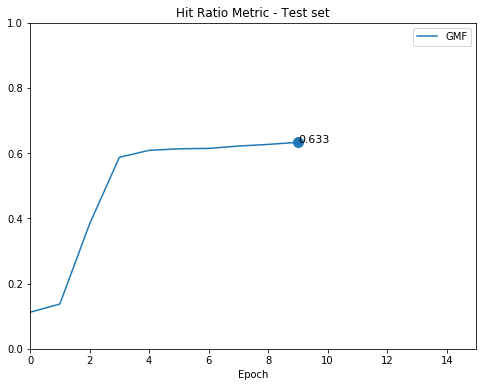

In [124]:
hr_gmf = np.load('metric/hr_vect_GMF.npy')

plt.figure(figsize=(8, 6))
plt.xlim([0,15])
plt.ylim([0,1.0])
plt.title('Hit Ratio Metric - Test set') # en realidad solo fue 60k por filtrado en fechas
plt.plot(hr_gmf)
plt.scatter(np.argmax(hr_gmf),np.max(hr_gmf),linewidths=5)
plt.text(np.argmax(hr_gmf),np.max(hr_gmf),np.round(np.max(hr_gmf),3), fontsize=11)
plt.legend(['GMF'],
           loc='upper right')
plt.xlabel('Epoch')
#plt.savefig('results_benf_ludnet_vs_ludnet_v2.png')
plt.show()

In [102]:
train_MLP(all_ratings,train_ratings,test_data,user_2_neg_items_vect,num_epochs=10)

C:\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, None)         0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         (None, None)         0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 8)         20208       user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 10)        322780      item_input[0][0]                 
__________________________________________________________________________________________________
flatten_27

100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1072.14it/s]
C:\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  app.launch_new_instance()


 training...
Epoch 1/1
 - 2s - loss: 0.6929 - acc: 0.5128
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:05<00:00, 481.60it/s]


 epoch 1 --> loss = 0.6929, ACC = 0.5128, HR = 0.1338
 Best model found!
EPOCH: 2 --------------------------------------------------------------------------------
 generating negatives...


100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1061.78it/s]


 training...
Epoch 1/1
 - 1s - loss: 0.6917 - acc: 0.5513
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:06<00:00, 420.30it/s]


 epoch 2 --> loss = 0.6917, ACC = 0.5513, HR = 0.2185
 Best model found!
EPOCH: 3 --------------------------------------------------------------------------------
 generating negatives...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:04<00:00, 558.36it/s]


 training...
Epoch 1/1
 - 1s - loss: 0.6861 - acc: 0.6075
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:06<00:00, 413.29it/s]


 epoch 3 --> loss = 0.6861, ACC = 0.6075, HR = 0.3599
 Best model found!
EPOCH: 4 --------------------------------------------------------------------------------
 generating negatives...


100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1126.68it/s]


 training...
Epoch 1/1
 - 1s - loss: 0.6685 - acc: 0.6701
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:04<00:00, 561.71it/s]


 epoch 4 --> loss = 0.6685, ACC = 0.6701, HR = 0.4683
 Best model found!
EPOCH: 5 --------------------------------------------------------------------------------
 generating negatives...


100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1241.89it/s]


 training...
Epoch 1/1
 - 1s - loss: 0.6326 - acc: 0.7176
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:04<00:00, 564.72it/s]


 epoch 5 --> loss = 0.6326, ACC = 0.7176, HR = 0.5360
 Best model found!
EPOCH: 6 --------------------------------------------------------------------------------
 generating negatives...


100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1237.62it/s]


 training...
Epoch 1/1
 - 1s - loss: 0.5871 - acc: 0.7433
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:04<00:00, 567.59it/s]


 epoch 6 --> loss = 0.5871, ACC = 0.7433, HR = 0.5649
 Best model found!
EPOCH: 7 --------------------------------------------------------------------------------
 generating negatives...


100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1254.25it/s]


 training...
Epoch 1/1
 - 1s - loss: 0.5456 - acc: 0.7585
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:04<00:00, 555.29it/s]


 epoch 7 --> loss = 0.5456, ACC = 0.7585, HR = 0.5748
 Best model found!
EPOCH: 8 --------------------------------------------------------------------------------
 generating negatives...


100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1216.16it/s]


 training...
Epoch 1/1
 - 1s - loss: 0.5186 - acc: 0.7654
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:04<00:00, 563.84it/s]


 epoch 8 --> loss = 0.5186, ACC = 0.7654, HR = 0.5812
 Best model found!
EPOCH: 9 --------------------------------------------------------------------------------
 generating negatives...


100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1247.40it/s]


 training...
Epoch 1/1
 - 1s - loss: 0.5022 - acc: 0.7701
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:04<00:00, 557.86it/s]


 epoch 9 --> loss = 0.5022, ACC = 0.7701, HR = 0.5871
 Best model found!
EPOCH: 10 --------------------------------------------------------------------------------
 generating negatives...


100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1216.75it/s]


 training...
Epoch 1/1
 - 1s - loss: 0.4911 - acc: 0.7745
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:04<00:00, 552.97it/s]


 epoch 10 --> loss = 0.4911, ACC = 0.7745, HR = 0.5867


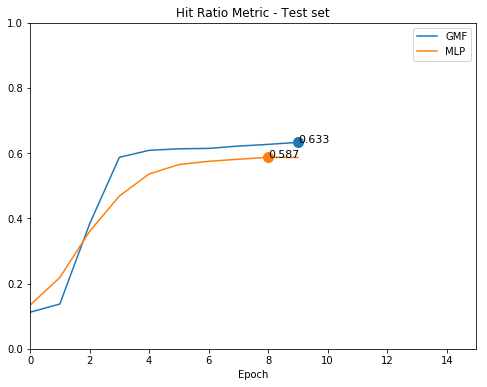

In [103]:
hr_gmf = np.load('metric/hr_vect_GMF.npy')
hr_mlp = np.load('metric/hr_vect_MLP.npy')

plt.figure(figsize=(8, 6))
plt.xlim([0,15])
plt.ylim([0,1.0])
plt.title('Hit Ratio Metric - Test set') # en realidad solo fue 60k por filtrado en fechas
plt.plot(hr_gmf)
plt.scatter(np.argmax(hr_gmf),np.max(hr_gmf),linewidths=5)
plt.text(np.argmax(hr_gmf),np.max(hr_gmf),np.round(np.max(hr_gmf),3), fontsize=11)
plt.plot(hr_mlp)
plt.scatter(np.argmax(hr_mlp),np.max(hr_mlp),linewidths=5)
plt.text(np.argmax(hr_mlp),np.max(hr_mlp),np.round(np.max(hr_mlp),3), fontsize=11)
plt.legend(['GMF','MLP'],
           loc='upper right')
plt.xlabel('Epoch')
#plt.savefig('results_benf_ludnet_vs_ludnet_v2.png')
plt.show()

In [117]:
train_model_NeuMF(all_ratings ,train_ratings ,test_data, user_2_neg_items_vect, num_epochs=10, pre_train=True)

C:\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, None)         0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         (None, None)         0                                            
__________________________________________________________________________________________________
mlp_embedding_user (Embedding)  (None, 1, 8)         20208       user_input[0][0]                 
__________________________________________________________________________________________________
mlp_embedding_item (Embedding)  (None, 1, 10)        322780      item_input[0][0]                 
__________________________________________________________________________________________________
flatten_55

C:\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`
C:\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`


Load pretrained GMF (%s) and MLP (%s) models done. 
Trainig loop...
EPOCH: 1 --------------------------------------------------------------------------------
 generating negatives...


100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1094.93it/s]
C:\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  app.launch_new_instance()


 training...
Epoch 1/1
 - 2s - loss: 0.4650 - acc: 0.7846
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:05<00:00, 492.41it/s]


 epoch 1 --> loss = 0.4650, ACC = 0.7846, HR = 0.6386
 Best model found!
EPOCH: 2 --------------------------------------------------------------------------------
 generating negatives...


100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1170.46it/s]


 training...
Epoch 1/1
 - 1s - loss: 0.4266 - acc: 0.8083
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:04<00:00, 513.84it/s]


 epoch 2 --> loss = 0.4266, ACC = 0.8083, HR = 0.6639
 Best model found!
EPOCH: 3 --------------------------------------------------------------------------------
 generating negatives...


100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1085.53it/s]


 training...
Epoch 1/1
 - 1s - loss: 0.3929 - acc: 0.8261
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:04<00:00, 560.53it/s]


 epoch 3 --> loss = 0.3929, ACC = 0.8261, HR = 0.6892
 Best model found!
EPOCH: 4 --------------------------------------------------------------------------------
 generating negatives...


100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1219.70it/s]


 training...
Epoch 1/1
 - 1s - loss: 0.3610 - acc: 0.8422
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:05<00:00, 454.81it/s]


 epoch 4 --> loss = 0.3610, ACC = 0.8422, HR = 0.7023
 Best model found!
EPOCH: 5 --------------------------------------------------------------------------------
 generating negatives...


100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1159.78it/s]


 training...
Epoch 1/1
 - 1s - loss: 0.3288 - acc: 0.8586
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:04<00:00, 549.14it/s]


 epoch 5 --> loss = 0.3288, ACC = 0.8586, HR = 0.7158
 Best model found!
EPOCH: 6 --------------------------------------------------------------------------------
 generating negatives...


100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1212.17it/s]


 training...
Epoch 1/1
 - 1s - loss: 0.3003 - acc: 0.8736
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:04<00:00, 556.50it/s]


 epoch 6 --> loss = 0.3003, ACC = 0.8736, HR = 0.7217
 Best model found!
EPOCH: 7 --------------------------------------------------------------------------------
 generating negatives...


100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1224.45it/s]


 training...
Epoch 1/1
 - 1s - loss: 0.2754 - acc: 0.8865
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:04<00:00, 514.99it/s]


 epoch 7 --> loss = 0.2754, ACC = 0.8865, HR = 0.7205
EPOCH: 8 --------------------------------------------------------------------------------
 generating negatives...


100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1082.47it/s]


 training...
Epoch 1/1
 - 1s - loss: 0.2547 - acc: 0.8972
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:04<00:00, 512.38it/s]


 epoch 8 --> loss = 0.2547, ACC = 0.8972, HR = 0.7177
EPOCH: 9 --------------------------------------------------------------------------------
 generating negatives...


100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1173.26it/s]


 training...
Epoch 1/1
 - 1s - loss: 0.2370 - acc: 0.9067
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:05<00:00, 440.14it/s]


 epoch 9 --> loss = 0.2370, ACC = 0.9067, HR = 0.7162
EPOCH: 10 --------------------------------------------------------------------------------
 generating negatives...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 951.19it/s]


 training...
Epoch 1/1
 - 1s - loss: 0.2222 - acc: 0.9148
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:06<00:00, 414.31it/s]


 epoch 10 --> loss = 0.2222, ACC = 0.9148, HR = 0.7205


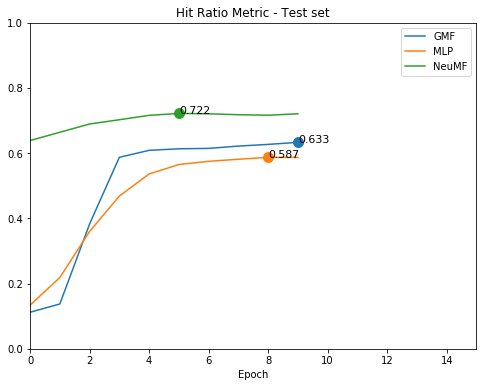

In [118]:
hr_gmf = np.load('metric/hr_vect_GMF.npy')
hr_mlp = np.load('metric/hr_vect_MLP.npy')
hr_neumf = np.load('metric/hr_vect_NeuMF.npy')

plt.figure(figsize=(8, 6))
plt.xlim([0,15])
plt.ylim([0,1.0])
plt.title('Hit Ratio Metric - Test set') # en realidad solo fue 60k por filtrado en fechas
plt.plot(hr_gmf)
plt.scatter(np.argmax(hr_gmf),np.max(hr_gmf),linewidths=5)
plt.text(np.argmax(hr_gmf),np.max(hr_gmf),np.round(np.max(hr_gmf),3), fontsize=11)
plt.plot(hr_mlp)
plt.scatter(np.argmax(hr_mlp),np.max(hr_mlp),linewidths=5)
plt.text(np.argmax(hr_mlp),np.max(hr_mlp),np.round(np.max(hr_mlp),3), fontsize=11)
plt.plot(hr_neumf)
plt.scatter(np.argmax(hr_neumf),np.max(hr_neumf),linewidths=5)
plt.text(np.argmax(hr_neumf),np.max(hr_neumf),np.round(np.max(hr_neumf),3), fontsize=11)
plt.legend(['GMF','MLP','NeuMF'],
           loc='upper right')
plt.xlabel('Epoch')
#plt.savefig('results_benf_ludnet_vs_ludnet_v2.png')
plt.show()

In [113]:
train_model_NeuMF(all_ratings ,train_ratings ,test_data, user_2_neg_items_vect, num_epochs=10, pre_train=False)

C:\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, None)         0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         (None, None)         0                                            
__________________________________________________________________________________________________
mlp_embedding_user (Embedding)  (None, 1, 8)         20208       user_input[0][0]                 
__________________________________________________________________________________________________
mlp_embedding_item (Embedding)  (None, 1, 10)        322780      item_input[0][0]                 
__________________________________________________________________________________________________
flatten_51

100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1128.17it/s]
C:\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  app.launch_new_instance()


 training...
Epoch 1/1
 - 2s - loss: 0.6931 - acc: 0.5059
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:05<00:00, 476.25it/s]


 epoch 1 --> loss = 0.6931, ACC = 0.5059, HR = 0.1306
 Best model found!
EPOCH: 2 --------------------------------------------------------------------------------
 generating negatives...


100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1236.40it/s]


 training...
Epoch 1/1
 - 1s - loss: 0.6926 - acc: 0.5282
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:04<00:00, 559.21it/s]


 epoch 2 --> loss = 0.6926, ACC = 0.5282, HR = 0.2074
 Best model found!
EPOCH: 3 --------------------------------------------------------------------------------
 generating negatives...


100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1226.78it/s]


 training...
Epoch 1/1
 - 1s - loss: 0.6903 - acc: 0.5674
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:05<00:00, 451.13it/s]


 epoch 3 --> loss = 0.6903, ACC = 0.5674, HR = 0.3341
 Best model found!
EPOCH: 4 --------------------------------------------------------------------------------
 generating negatives...


100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1147.14it/s]


 training...
Epoch 1/1
 - 1s - loss: 0.6831 - acc: 0.6197
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:04<00:00, 536.88it/s]


 epoch 4 --> loss = 0.6831, ACC = 0.6197, HR = 0.4410
 Best model found!
EPOCH: 5 --------------------------------------------------------------------------------
 generating negatives...


100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1036.73it/s]


 training...
Epoch 1/1
 - 1s - loss: 0.6670 - acc: 0.6643
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:05<00:00, 463.13it/s]


 epoch 5 --> loss = 0.6670, ACC = 0.6643, HR = 0.5139
 Best model found!
EPOCH: 6 --------------------------------------------------------------------------------
 generating negatives...


100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1222.70it/s]


 training...
Epoch 1/1
 - 1s - loss: 0.6397 - acc: 0.6991
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:04<00:00, 530.45it/s]


 epoch 6 --> loss = 0.6397, ACC = 0.6991, HR = 0.5455
 Best model found!
EPOCH: 7 --------------------------------------------------------------------------------
 generating negatives...


100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1205.16it/s]


 training...
Epoch 1/1
 - 1s - loss: 0.6061 - acc: 0.7204
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:04<00:00, 555.40it/s]


 epoch 7 --> loss = 0.6061, ACC = 0.7204, HR = 0.5606
 Best model found!
EPOCH: 8 --------------------------------------------------------------------------------
 generating negatives...


100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1164.06it/s]


 training...
Epoch 1/1
 - 1s - loss: 0.5735 - acc: 0.7338
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:04<00:00, 561.46it/s]


 epoch 8 --> loss = 0.5735, ACC = 0.7338, HR = 0.5709
 Best model found!
EPOCH: 9 --------------------------------------------------------------------------------
 generating negatives...


100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1078.57it/s]


 training...
Epoch 1/1
 - 1s - loss: 0.5484 - acc: 0.7429
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:05<00:00, 450.75it/s]


 epoch 9 --> loss = 0.5484, ACC = 0.7429, HR = 0.5748
 Best model found!
EPOCH: 10 --------------------------------------------------------------------------------
 generating negatives...


100%|████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:02<00:00, 1121.66it/s]


 training...
Epoch 1/1
 - 1s - loss: 0.5318 - acc: 0.7486
 testing...


100%|█████████████████████████████████████████████████████████████████████████████| 2526/2526 [00:05<00:00, 441.99it/s]


 epoch 10 --> loss = 0.5318, ACC = 0.7486, HR = 0.5812
 Best model found!


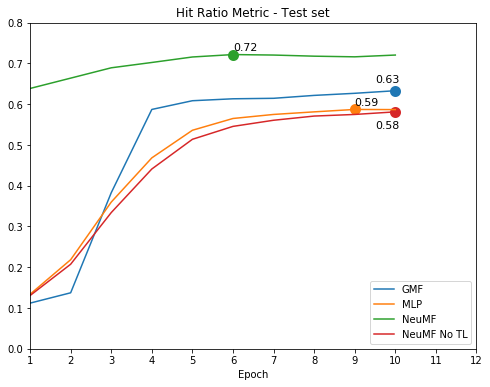

In [160]:
hr_gmf = np.load('metric/hr_vect_GMF.npy')
hr_mlp = np.load('metric/hr_vect_MLP.npy')
hr_neumf = np.load('metric/hr_vect_NeuMF.npy')
hr_neumf_noTF = np.load('metric/hr_vect_NeuMF_noTF.npy')

plt.figure(figsize=(8, 6))
plt.xlim([1,12])
plt.ylim([0,0.8])
plt.xticks(range(1,13))
plt.title('Hit Ratio Metric - Test set') # en realidad solo fue 60k por filtrado en fechas

plt.plot(range(1,11),hr_gmf)
plt.scatter(np.argmax(hr_gmf)+1,np.max(hr_gmf),linewidths=5)
plt.text(np.argmax(hr_gmf)+0.5,np.max(hr_gmf)+0.02,np.round(np.max(hr_gmf),2), fontsize=11)

plt.plot(range(1,11),hr_mlp)
plt.scatter(np.argmax(hr_mlp)+1,np.max(hr_mlp),linewidths=5)
plt.text(np.argmax(hr_mlp)+1,np.max(hr_mlp)+0.01,np.round(np.max(hr_mlp),2), fontsize=11)

plt.plot(range(1,11),hr_neumf)
plt.scatter(np.argmax(hr_neumf)+1,np.max(hr_neumf),linewidths=5)
plt.text(np.argmax(hr_neumf)+1,np.max(hr_neumf)+0.01,np.round(np.max(hr_neumf),2), fontsize=11)

plt.plot(range(1,11),hr_neumf_noTF)
plt.scatter(np.argmax(hr_neumf_noTF)+1,np.max(hr_neumf_noTF),linewidths=5)
plt.text(np.argmax(hr_neumf_noTF)+0.5,np.max(hr_neumf_noTF)-0.04,np.round(np.max(hr_neumf_noTF),2), fontsize=11)

plt.legend(['GMF','MLP','NeuMF','NeuMF No TL'],
           loc='lower right')
plt.xlabel('Epoch')
#plt.savefig('results_benf_ludnet_vs_ludnet_v2.png')
plt.show()

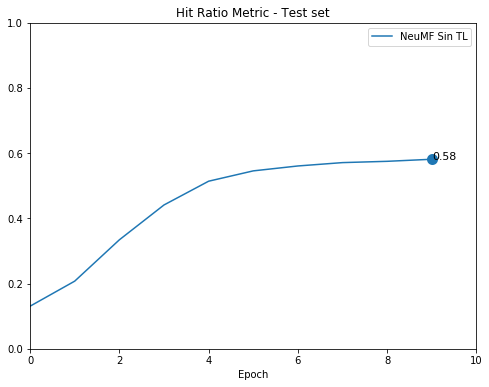

In [125]:
hr_neumf_noTF = np.load('metric/hr_vect_NeuMF_noTF.npy')

plt.figure(figsize=(8, 6))
plt.xlim([0,10])
plt.ylim([0,1.0])
plt.title('Hit Ratio Metric - Test set') # en realidad solo fue 60k por filtrado en fechas
plt.plot(hr_neumf_noTF)
plt.scatter(np.argmax(hr_neumf_noTF),np.max(hr_neumf_noTF),linewidths=5)
plt.text(np.argmax(hr_neumf_noTF),np.max(hr_neumf_noTF),np.round(np.max(hr_neumf_noTF),2), fontsize=11)
plt.legend(['NeuMF Sin TL'],
           loc='upper right')
plt.xlabel('Epoch')
plt.savefig('results1.png')
plt.show()

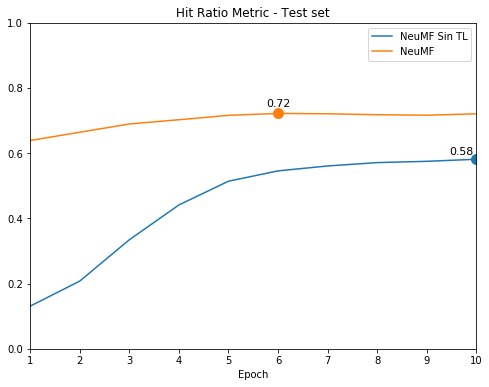

In [161]:
hr_neumf = np.load('metric/hr_vect_NeuMF.npy')
hr_neumf_noTF = np.load('metric/hr_vect_NeuMF_noTF.npy')

plt.figure(figsize=(8, 6))
plt.xlim([1,10])
plt.ylim([0,1.0])
plt.title('Hit Ratio Metric - Test set') # en realidad solo fue 60k por filtrado en fechas

plt.plot(range(1,11),hr_neumf_noTF)
plt.scatter(np.argmax(hr_neumf_noTF)+1,np.max(hr_neumf_noTF),linewidths=5)
plt.text(np.argmax(hr_neumf_noTF)+0.7,np.max(hr_neumf_noTF)+0.01,np.round(np.max(hr_neumf_noTF),2), fontsize=11,
        horizontalalignment='center',verticalalignment='bottom')
plt.plot(range(1,11),hr_neumf)
plt.scatter(np.argmax(hr_neumf)+1,np.max(hr_neumf),linewidths=5)
plt.text(np.argmax(hr_neumf)+1,np.max(hr_neumf)+0.02,np.round(np.max(hr_neumf),2), fontsize=11,
         horizontalalignment='center')
plt.legend(['NeuMF Sin TL','NeuMF'],
           loc='upper right')
plt.xlabel('Epoch')
plt.savefig('results2.png')
plt.show()

In [163]:
json_file = open('models/NeuMF_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

NeuMF_best = model_from_json(loaded_model_json)
NeuMF_best.load_weights('models/NeuMF_weights')

In [180]:
num_user = 64  #0 #10 #20 #1982 #2108 #1357 #64
user_not_interacted_artists = user_2_neg_items_vect[num_user]
user_not_interacted_vect_id = [num_user]*(len(user_not_interacted_artists))

user_dfneg_dict = {'user_id':user_not_interacted_vect_id,
                   'item_id':user_not_interacted_artists}
user_dfneg = pd.DataFrame(user_dfneg_dict)

user_df = pd.concat([all_ratings[all_ratings['user_id']==num_user], user_dfneg],axis=0,ignore_index=True)
user_df = user_df.sample(frac=1).reset_index(drop=True) #shuffle and reset index (drop old index)

user_df['prediction']= NeuMF_best.predict([user_df['user_id'], user_df['item_id']])

user_df = user_df.sort_values('prediction',ascending=False)
user_df['artist'] = user_df['item_id'].map(itemid2item)
user_df.prediction = user_df.prediction.round(4)
#user_df.loc[:,['user_id','plays','artist','prediction']].head(20)
a = user_df[pd.isnull(user_df).any(axis=1)].loc[:,['user_id','plays','artist','prediction']].head(5)

C:\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  if __name__ == '__main__':


In [181]:
# 'Electronica, Techno', 'Techno, Ambient music','Techno','Psychedelic trance','Electronica, Soul music'
# 'Rock, Pop music', 'Rock, Experimental music, Blues, Jazz', 'Alternative rock, Art rock, Alternative country, experimental rock, Indie rock','Indie rock, Alternaive rock, Lo-fi music','Art rock, Electronica, Alternative rock, Experimental rock'
# 'Melodic death metal', 'Heavy metal, Trash metal', 'Melodic death metal','Progressive metal','Brutal death metal'

In [183]:
a['music genre'] = ['House music',
                    'Dance/Electronic',
                    'Eletronica',
                    'Dance/Electronic',
                    'Techno']
a

,user_id,plays,artist,prediction,music genre
30921,64,NaN,gui boratto,0.9980,House music
1086,64,NaN,dusty kid,0.9961,Dance/Electronic
16636,64,NaN,thievery corporation,0.9960,Eletronica
26112,64,NaN,extrawelt,0.9960,Dance/Electronic
3760,64,NaN,paul kalkbrenner,0.9958,Techno


In [176]:
user_df = user_df.sort_values('plays',ascending=False)
b = user_df[user_df['plays']>0].loc[:,['user_id','plays','artist']].head(5)

In [177]:
# 'Electronica', 'Dubstep, Ambient music','Alternative Rock','Alternative Indie'

In [178]:
b['music genre'] = ['Garage rock, Garage punk',
                    'Alternative rock, Funk metal, Funk rock, Ska punk',
                    'Punk Rock, Melodic Hardcore, Hardcore Punk',
                    'Garage Punk, Garage rock, Punk rock',
                    'Post Hardcore, Art punk, Hardcore Punk']
b

,user_id,plays,artist,music genre
518,1357,2006.0,iron maiden,"Garage rock, Garage punk"
23347,1357,1051.0,mfÖ,"Alternative rock, Funk metal, Funk rock, Ska punk"
7388,1357,1033.0,sacred reich,"Punk Rock, Melodic Hardcore, Hardcore Punk"
17302,1357,621.0,massive attack,"Garage Punk, Garage rock, Punk rock"
18159,1357,576.0,destruction,"Post Hardcore, Art punk, Hardcore Punk"


In [ ]:
# from keras.utils import plot_model
# plot_model(NeuMF_best, to_file='model.png')